## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.sats2backtest as s2b
import src.timeutils as tu

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (169705, 8)


### Generate Candles and build features from technical analysis

In [5]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()

# Generate normalized timeseries

In [6]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

ts_btc.x_candles
ts_btc.x_time
ts_btc.y[-10:]

Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


[0.366681143387826,
 0.3669507381762064,
 0.36680105434233357,
 0.3651792973782567,
 0.3657543600879529,
 0.3654636420334786,
 0.3659557595043317,
 0.3660145768745761,
 0.36613712823734545,
 0.3661746402443744]

## Train CNN-LSTM model using full or part of data set

In [7]:
btc_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.95)
btc_model.sats2model()

In [64]:
datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')

'220625_17_16'

In [65]:
MODELDATE_TO_SAVE = datetime.strptime(str(can_btc.candles.index[-1]), '%Y-%m-%d %H:%M:%S').strftime('%y%m%d_%H_%M')
PRESAVED_MODELDATE = "220625_17_16"

if PRESAVED_MODELDATE == MODELDATE_TO_SAVE :
  model_name = f"model/LSTM_CNN_pretrained_{MODELDATE_TO_SAVE}"
else:
  model_name = "model/LSTM_CNN_model"

btc_model.sats2train(model_name, save_model = True, epochs=20)

Epoch 1/20
11/11 [==============================] - 1s 109ms/step - loss: 0.0071 - val_loss: 0.0083
Epoch 2/20
11/11 [==============================] - 1s 87ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 3/20
11/11 [==============================] - 1s 101ms/step - loss: 0.0059 - val_loss: 0.0100
Epoch 4/20
11/11 [==============================] - 1s 86ms/step - loss: 0.0060 - val_loss: 0.0037
Epoch 5/20
11/11 [==============================] - 1s 87ms/step - loss: 0.0059 - val_loss: 0.0082
Epoch 6/20
11/11 [==============================] - 1s 87ms/step - loss: 0.0059 - val_loss: 0.0033
Epoch 7/20
11/11 [==============================] - 1s 87ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 8/20
11/11 [==============================] - 1s 87ms/step - loss: 0.0059 - val_loss: 0.0032
Epoch 9/20
11/11 [==============================] - 1s 87ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 10/20
11/11 [==============================] - 1s 87ms/step - loss: 0.0059 - val_loss: 0.0030
Epoch 1

INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


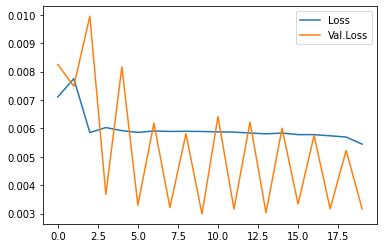

In [66]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

### Retrain for longer

In [67]:
btc_model.sats2train(model_name, save_model = True, epochs=500)

Epoch 1/100
11/11 [==============================] - 1s 107ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 2/100
11/11 [==============================] - 1s 101ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 3/100
11/11 [==============================] - 1s 104ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 4/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0057 - val_loss: 0.0070
Epoch 5/100
11/11 [==============================] - 1s 86ms/step - loss: 0.0056 - val_loss: 0.0028
Epoch 6/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0055 - val_loss: 0.0062
Epoch 7/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 8/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 9/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0057 - val_loss: 0.0028
Epoch 10/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0055 - val_loss: 0.0

INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


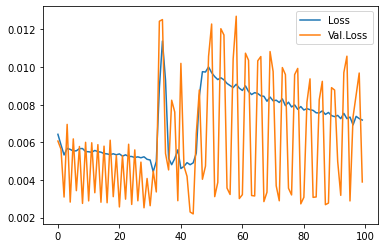

In [68]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [69]:
btc_model.sats2pred()

In [70]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(btc_model.scaler, ts_btc.candles, btc_model.preds)

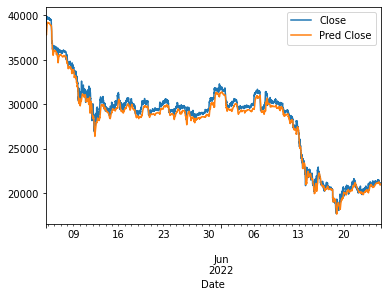

In [71]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = 1)
df_preds_true.dropna().plot()

## Test on pretrained model

In [17]:
USE_PRETRAINED = False

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.95)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = True)
loaded_model.preds

array([[0.5284108 ],
       [0.5285249 ],
       [0.5284525 ],
       ...,
       [0.3742433 ],
       [0.3741536 ],
       [0.37403578]], dtype=float32)

In [18]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(loaded_model.scaler, ts_btc.candles, loaded_model.preds)

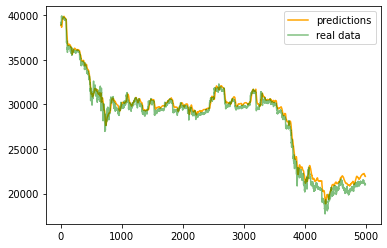

In [19]:
plt.plot(preds, color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point+ts_btc.step_back:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

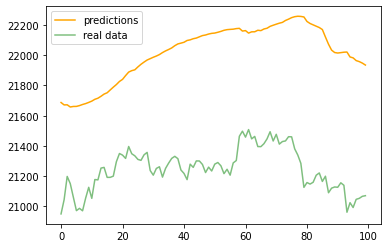

In [20]:
plt.plot(preds[-100:], color='orange', label='predictions')
plt.plot(true_vals[-100:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

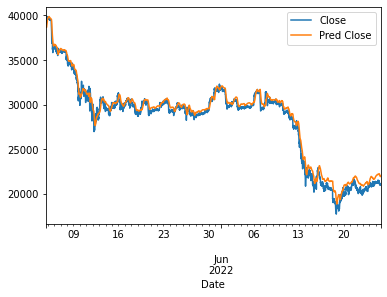

In [55]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = 1)
df_preds_true.dropna().plot()

In [56]:
df_preds_true.dropna()

,Close,Pred Close
Date,,
2022-05-04 16:46:00,39189.99,38889.849940
2022-05-04 17:01:00,38953.44,38902.379879
2022-05-04 17:16:00,38956.10,38894.432467
2022-05-04 17:31:00,38924.89,38896.612441
2022-05-04 17:46:00,38985.30,38901.797243
...,...,...
2022-06-25 16:16:00,20993.12,21988.065475
2022-06-25 16:31:00,21047.17,21982.082004
2022-06-25 16:46:00,21053.63,21964.062852


In [57]:
np.array(true_vals[btc_model.split_point+ts_btc.step_back+1:])

array([39189.99, 38953.44, 38956.1 , ..., 21053.63, 21067.09, 21071.21])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


Fee: 0.025
----------------------
Buy      1099 ( 614 ok 485 ko )
Avg PCT gain: 1.0045047938651792
Avg PCT loss: 0.9961579955373039
Wins  PCT   0.5586897179253867
Avg PCT Gain.    1.0045047938651792
No-op    0
Wallet   19925.14175000002
Drawback -1549.9947499999987
Kelly Fraction    0.12104644465649633
Total earned 19925.14175000002


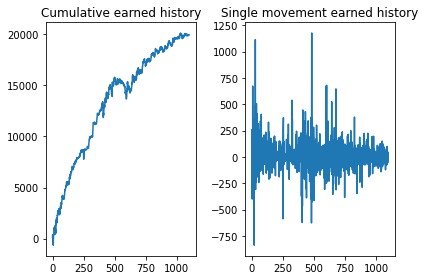

In [63]:
total_wallet_history, single_wallet_history, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna(), ts_btc.step_back, long_short = "long", fee=0.025)
s2b.show_backtest_results(wallet,total_wallet_history,single_wallet_history)

Fee: 0.025
----------------------
Buy      1105 ( 617 ok 488 ko )
Wallet   20088.707250000003
Drawback -1549.9947499999987
Total earned 20088.707250000003


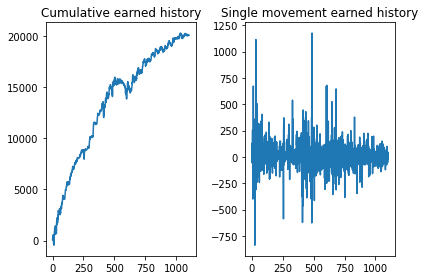

In [59]:
total_wallet_history, single_wallet_history, wallet = s2b.backtest_debug(preds, true_vals, btc_model.split_point, ts_btc.step_back, fee=0.025)
s2b.show_backtest_results(wallet,total_wallet_history,single_wallet_history)